# Hydrostatics of submerged cylinder

## Summary of the Notebook

This notebook demonstrates a numerical approach to evaluate the submerged depth of arbitrarily shaped bodies, specifically cylindrical structures, in a fluid. It includes the following steps:

1. **Constants Definition**: Physical constants such as gravitational acceleration, water density, and domain dimensions are defined.
2. **Cylindrical Structures**: Cylindrical objects are modeled with their geometry and nodes, and their elements are visualized.
3. **Static Pressure Calculation**: A function is implemented to compute the static pressure distribution in the fluid.
4. **Visualization**: The static pressure field and the cylindrical structures are plotted for better understanding.
5. **Force Calculation**: The forces acting on the cylindrical structures due to the pressure distribution are computed using numerical integration.
6. **Draft Calculation**: The submerged depth (draft) of floating cylindrical bodies is determined by solving a nonlinear equation using numerical optimization.
7. **Final Visualization**: The pressure field and the equilibrium positions of the floating cylinders are visualized.

This approach provides insights into hydrostatics and the interaction of submerged bodies with fluid pressure fields.

In [14]:
import numpy as np
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

## Define Variables

- `g`: Gravitational acceleration (m/s²).
- `rhoW`: Density of water (kg/m³).
- `d`: Depth of water (m).

For visualising the pressure contour

- `xdom`: Tuple defining the x-domain range (start, end) for the simulation (m).
- `dx`: Step size in the x-direction (m).
- `dz`: Step size in the z-direction (m).

In [15]:
# Constants 
g = 9.81  #m/s2
rhoW = 1000  #kg/m3
d = 10 #m (water-depth)
xdom = (0, 30)
dx = 1
dz = 1

## Define cylindrical structures

- We will use the concept of finite elements for this problem.
- It will therefore serve as a simple problem to understand the FE concepts

Let us now define some function which will be requred for this analysis.

### Class `Cyl`
#### Function `__init__()`:

- Inputs: It takes the center position `(x0, z0)`, radius (`R`), and angular step size (`dth`) as inputs.
- Process: It creates a mesh to define the cylinder surface. 
    - This is done simply by defining the position of the nodes as nodes on the circle
    - Define a connectivitiy array `self.Ele`, containing the node associated with the element in the anti-clockwise order
    - We also initialise a pressure field `self.P` on these nodes. This will be used later for calculating the buoyant force on the structure.

#### Function `plotEle()`:

- This function will plot the cylinder in the 2D space, based on the provided position of the centre `(x0, z0)` and the radius `R` of the cylinder

In [16]:
class Cyl:
    def __init__(self, x0, z0, R, dth):
        thMat = np.arange(0, 360, dth) #deg
        cx = x0 + R*np.cos( np.deg2rad(thMat) )
        cz = z0 + R*np.sin( np.deg2rad(thMat) )
        self.cx = cx
        self.cz = cz
        self.NodeC = [ [x, z] for x,z in zip (cx, cz) ]
        self.nNode = len(self.NodeC)
        self.Ele = [ [n1, n2] for n1,n2 in 
                    zip( range(0,self.nNode-1), range(1,self.nNode)) ]
        self.Ele.append([self.nNode-1, 0])
        self.nEle = len(self.Ele)
        self.P = np.zeros(self.nNode)
        
    def plotEle(self):        
        for iEle in range(0,self.nEle):
            n1, n2 = self.Ele[iEle]
            n1 = int(round(n1))
            n2 = int(round(n2))
            plt.plot( [self.NodeC[n1][0], self.NodeC[n2][0]],
                     [self.NodeC[n1][1], self.NodeC[n2][1]],
                     lw=3, color='k')        
            
        
# Cyl(x0, z0, R, dthDeg):

### Function `gaussQuad2P`:

This function, gaussQuad2P, calculates the integral of a scalar field (e.g., pressure) multiplied by the normal vector of a surface along the entire domain using the 2-point Gaussian quadrature method. 

$$
\vec{F} = \int_\Omega p \, \vec{n} \, d\Omega
$$


It works by:

- Iterating over all elements of the surface.
- Computing the length of each element and its normal vector.
- Evaluating the scalar field at two Gaussian quadrature points within each element.
- Summing the contributions of these points to the total force components (sumFx and sumFz) in the x and z directions.
- This method ensures accurate numerical integration of the scalar field over the surface.



In [17]:
def gaussQuad2P( nEle, nNode, Ele, NodeC, P):
    sumFx = 0.0
    sumFz = 0.0
    for iEle in range(0,nEle):
        n1, n2 = Ele[iEle]
        n1 = int(round(n1))
        n2 = int(round(n2))
        x1,z1 = NodeC[n1]
        x2,z2 = NodeC[n2]
        p1 = P[n1]
        p2 = P[n2]
        
        lele = np.sqrt( (x2-x1)**2 + (z2-z1)**2 )        
        nx = (z2-z1)/lele
        nz = -(x2-x1)/lele
        
        ep1 = 0.5*(1-1/np.sqrt(3))
        ep2 = 0.5*(1+1/np.sqrt(3))
        q1p = (1-ep1)*p1 + ep1*p2
        q2p = (1-ep2)*p1 + ep2*p2
        sumFx += (q1p + q2p)*lele/2*(-nx)
        sumFz += (q1p + q2p)*lele/2*(-nz)
    return sumFx, sumFz

pass

## Define pressure

### Function `statPressure` 

- The function calculates the static pressure at a given point in the fluid. 

#### Inputs:
- `x`: x-coordinate(s) of the point(s) (m).
- `z`: z-coordinate(s) of the point(s) (m).

#### Outputs:
- `Ps`: Static pressure at the given point(s) (Pa).

#### Process:
- The function computes the pressure using the formula `Ps = -rhoW * g * z`, where `rhoW` is the density of water and `g` is the gravitational acceleration.
- If the calculated pressure is negative (above the water surface), it is set to zero using `np.maximum`.

In [18]:
# Function to define static pressure
def statPressure(x,z):
    Ps = -rhoW * g * z
    Psz = 0*Ps
    Ps = np.maximum(Ps, Psz)
    return Ps

## Initilise cylinders

Now using the class `Cyl` we initilise two cylinders, one fully sumerged and one partially submerged.

In [19]:
cyl1 = Cyl(10, -5, 2, 0.1)
cyl2 = Cyl(20, 0, 2, 0.1)

## Visualize everything

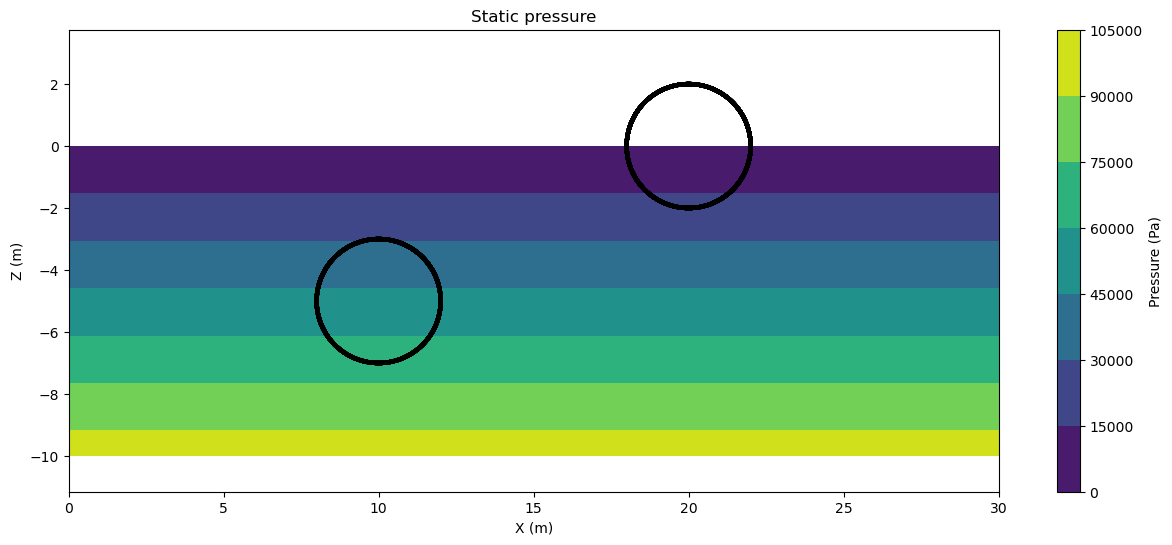

In [20]:
[X, Z] = np.meshgrid( np.arange(xdom[0], xdom[1]+1, 1), np.arange(-d, 0+1, 1) )
Ps = statPressure(X, Z)

plt.figure(1)
plt.contourf(X, Z, Ps)
plt.title('Static pressure')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
cbar = plt.colorbar()
cbar.set_label('Pressure (Pa)')

cyl1.plotEle()
cyl2.plotEle()

#plt.grid("on")
plt.axis("equal")
plt.show()
pass

## Calculate force

- We first initilise the static pressure on the nodes of the two cylinders.
- For this we pass the array of all nodes of the cylinder in the `statPressure` function and obtain the corresponsidoing static pressure.

### THINK:

How would you modify function to analyse the dynamic pressure on the cylinder due to wave action ?

In [21]:
cyl1.P = statPressure( cyl1.cx, cyl1.cz )
cyl2.P = statPressure( cyl2.cx, cyl2.cz )

After the definition of the pressure field, we now use the function `gaussQuad2P` to integrate the pressure field multiplied with the surface normal, along the entire surface.

In [22]:
cyl1.Fx, cyl1.Fz = gaussQuad2P( cyl1.nEle, cyl1.nNode, 
                               cyl1.Ele, cyl1.NodeC, cyl1.P )
cyl2.Fx, cyl2.Fz = gaussQuad2P( cyl2.nEle, cyl2.nNode, 
                               cyl2.Ele, cyl2.NodeC, cyl2.P )

print("Cyl1 Fx Fz", cyl1.Fx, cyl1.Fz)
print("Cyl2 Fx Fz ", cyl2.Fx, cyl2.Fz)

Cyl1 Fx Fz -2.8279600883251987e-11 123276.0331401297
Cyl2 Fx Fz  -3.370873025154708e-12 61638.01657006472


## Solve for draft of floating body

Let us go a step further and now invert the problem. We will assume that we know the force, lets say the weight of the body and we want to find depth of submergence, or the draft, of the body. 

We do this by a iterative procedure.

- The provided function `objectove_fnc()` defines an objective function that calculates the difference (error) between the buoyant force acting on a submerged cylindrical body (based on its assumed draft) and the predefined weight of the body. 
- This function is used in an iterative numerical solver (`optimize.fsolve()`) to adjust the draft until the buoyant force matches the weight, thereby determining the equilibrium submerged depth of the body.


In [23]:
def objective_fnc(sol,*data):    
    z0 = sol
    x0, R, dth, Fztarg = data
    cyl = Cyl(x0, z0, R, dth)
    cyl.P = statPressure( cyl.cx, cyl.cz )
    cyl.Fx, cyl.Fz = gaussQuad2P( cyl.nEle, cyl.nNode, 
                                   cyl.Ele, cyl.NodeC, cyl.P )    
    return (cyl.Fz - Fztarg)

cylWei = 100000 #kg
data = (10, 2, 0.5, cylWei)
root = optimize.fsolve(objective_fnc,-1,args=data)
print("Numerically calculated z0 = ",root)
cyl3  = Cyl( data[0], root, data[1], data[2] )

cylWei = 20000 #kg
data = (20, 2, 0.5, cylWei)
root = optimize.fsolve(objective_fnc,-1,args=data)
print("Numerically calculated z0 = ",root)
cyl4  = Cyl( data[0], root, data[1], data[2] )

Numerically calculated z0 =  [-1.0244031]
Numerically calculated z0 =  [1.12334122]


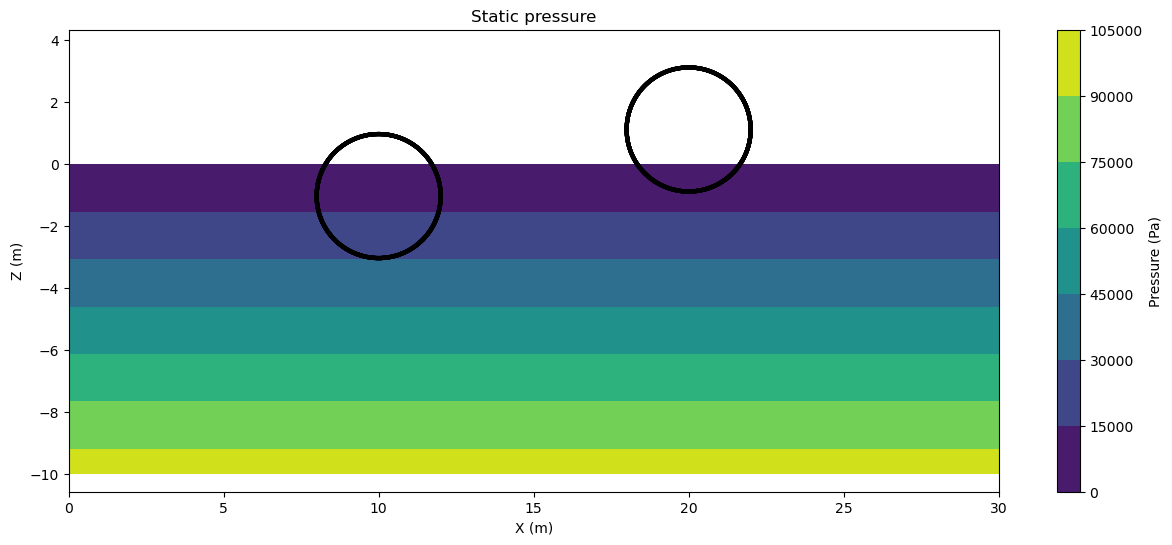

In [24]:
[X, Z] = np.meshgrid( np.arange(xdom[0], xdom[1]+1, 1), np.arange(-d, 0+1, 1) )
Ps = statPressure(X, Z)


plt.contourf(X, Z, Ps)
plt.title('Static pressure')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
cbar = plt.colorbar()
cbar.set_label('Pressure (Pa)')

cyl3.plotEle()
cyl4.plotEle()

#plt.grid("on")
plt.axis("equal")
plt.show()
pass